In [1]:
from rasterstats import zonal_stats
import geopandas as gpd

import os
import numpy as np
import matplotlib.pyplot as plt

from configs.config_object import ConfigObject

In [7]:
config = ConfigObject('../configs/config.json')

## Load bathymetry asc files

See at the end of the notebook if merging of different tiles is necessary

In [8]:
raw_bathy_path = config.paths.raw_bathy_path #input
path_grid = config.paths.grid_folder_path #output

## Load MITgcm grid

In [5]:
grid = gpd.read_file(os.path.join(path_grid, f"grid_epsg{config.epsg_projection}.gpkg"))

# to get the grid shape
with open(os.path.join(path_grid, f'x_epsg{config.epsg_projection}_grid.npy'), 'rb') as f:
    x = np.load(f)

## Compute average depth per cell

In [29]:
# Compute zonal statistics
stats = zonal_stats(grid, raw_bathy_path, stats="mean", nodata=-9999)

In [30]:
grid["avg_altitude"] = [s["mean"] for s in stats]

In [31]:
grid["avg_altitude"].max()

562.0091853035144

In [32]:
grid["avg_altitude"].min()

219.863825

In [33]:
grid["avg_depth"] = grid["avg_altitude"] - config.lake_altitude

In [34]:
config.lake_altitude

434

In [35]:
grid["avg_altitude"].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: avg_altitude, dtype: float64

In [36]:
grid["avg_depth"] = grid["avg_depth"].fillna(2)
depth_array = grid["avg_depth"].to_numpy().reshape(x.shape)

Text(0.5, 1.0, 'Depth (m)')

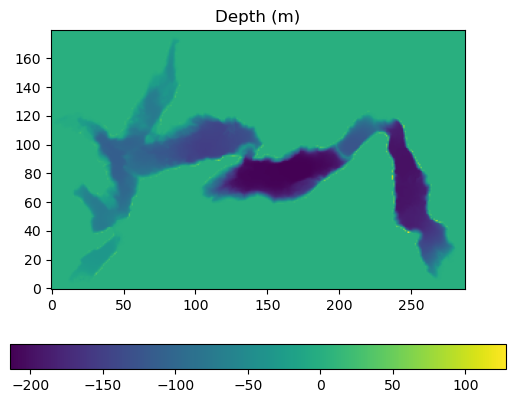

In [43]:
plt.imshow(depth_array)
plt.gca().invert_yaxis()
cbar = plt.colorbar(orientation="horizontal")
plt.title("Depth (m)")

## Save bathymetry

In [44]:
# Write gpkg file
grid.to_file(os.path.join(config.paths.grid_folder_path, "grid_with_depth_epsg2056.gpkg"), driver="GPKG")

In [45]:
# Write binary file
fid = open(os.path.join(config.paths.grid_folder_path, "bathy.bin"), 'wb')
depth_array.astype('>f8').tofile(fid)
fid.close()

# UTILS

# Use to merge different tiles into one .tif file
import glob
import rasterio
from rasterio.merge import merge

# Find all .asc files
asc_files = glob.glob("C:\Users\leroquan\Documents\Data\bathymetry\lucerne\swissbathy3d_vierwaldstaettersee_2056_5728.esriasciigrid\*.asc)

# Open all the .asc files with rasterio
src_files_to_mosaic = []
for fp in asc_files:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

# Merge them into a single mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

# Copy metadata from one of the source files and update
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "dtype": mosaic.dtype
})

# Write the mosaic to disk
output_tif = os.path.join(raw_bathy_path, 'merged_output.tif')
with rasterio.open(output_tif, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"Merged {len(asc_files)} .asc files into {output_tif}")
